# Accurate Toeplitz Matrix Calcurate

In [5]:
using PyCall
using PyPlot

scipy_ndimage = pyimport("scipy.ndimage")

function Fourier_permittivity(Nx, Ny, x_start, x_end, y_start, y_end, n, angle)
    
    A = ones(Float64, Nx, Ny) 

    A[y_start + 1:y_end, x_start + 1:x_end] .= n
    #A[x_start:x_end, y_start:y_end] .= n

    # Calculate the center of the rectangle
    center_x = div(x_start + x_end, 2)
    center_y = div(y_start + y_end, 2)

    # Rotate rectangle around its center using scipy's rotate function
    A_rotated = scipy_ndimage.rotate(A, angle, reshape=false, order=1, cval=1)

    # permittivity figure
    PyPlot.imshow(A_rotated, cmap="viridis", origin="lower")
    PyPlot.colorbar(label="permittivity")
    PyPlot.xlabel("x")
    PyPlot.ylabel("y")
    PyPlot.grid(true, linestyle="dotted", color="white")
    PyPlot.title("Permittivity distribution")
    PyPlot.show()

    return A_rotated
end

Fourier_permittivity (generic function with 1 method)

# Permittivity distribution

sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


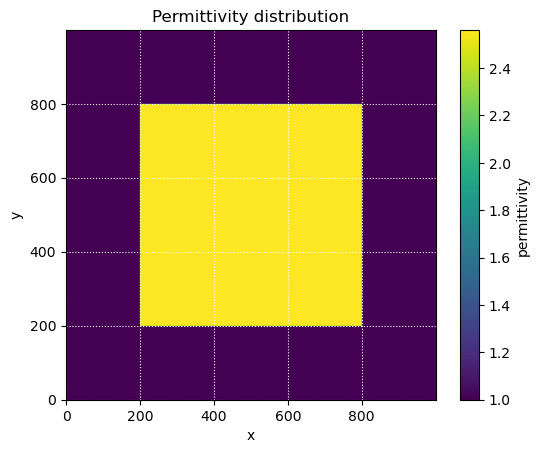

In [10]:
###### parameters
Rex = 1000
Rey = 1000
y_start = 200
x_start = 200
y_end = 800
x_end = 800
n = 1.6^2
angle = 0

F_1 = Fourier_permittivity(Rex, Rey, x_start, x_end, y_start, y_end, n, angle);

# Reciprocal of Permittivity distribution 
# $\frac{1}{\epsilon(x,y)}$

In [11]:
using FFTW

F_r = 1 ./ F_1;

In [12]:
(1 / Rex) * fftshift(fft(F_r[5, :]));

# サンプル数 M - 1　個の係数

### -2N ~ 2N まで$\frac{1}{\epsilon(x,y)}$の$y_p$点のフーリエ係数をxに関して計算し、Toeplitz行列に変換

### $\alpha(y_p)は$$y_p$におけるTpeplitz行列の逆行列を1行にしたもの

### $\alpha(y_p)$を一行に直して以下のように縦に並べる
$ [\frac{1}{\epsilon(x,y)}]^{-1}=\left[
\begin{array}{cc} 
\alpha(y_1) \\ \alpha(y_2) \\ ...\\ \alpha(y_p)\\ ...\\ \alpha(y_M)
\end{array}
\right]
$

In [13]:
#using ToeplitzMatrices, Test, LinearAlgebra
using ToeplitzMatrices, LinearAlgebra
using FFTW

# サンプリング数が偶数の時

P = 2

nn = Int(P * 2 + 1)

nnn = nn * nn

Af_a = zeros(Complex{Float64}, Rex, nnn)

#　関数作るときはサンプリング数の偶奇で場合分け

A_array = []

for i in 1 : Rex
    
    ## do fft xに沿っって
    Af = (1 / Rex) * fftshift(fft(F_r[i, :]'))

    Af_r = reverse(Af)
    
    o_0 = Int((length(Af) + 2) / 2)

    # o_0 is 0 order amplitude
    # N is 2 times of max order for Fourier 
    # P is max order for Fourier 

    N = Int(2 * P)

    # make the Toeplitz matrix center part is o_0
    
    Af_matrix = Toeplitz(Af_r[o_0 - 1 : o_0 - 1 + N], Af[o_0 : o_0 + N])

    #push!(A_array, Af_matrix)

    #print(size(Af_matrix))

    II = Matrix{Complex{Float64}}(I, nn, nn)

    # calculate inverse of Toeplitz matrix
    
    Af_matrix = II / Af_matrix

    # 逆行列を 1行　 に並べる  nn * nn 要素数

    Af_a[i, :] = vec(Af_matrix')'

    push!(A_array, Af_matrix)
    
end

#==
PyPlot.imshow(abs.(A_array[510]), cmap="viridis", origin="lower")
PyPlot.colorbar(label="Toeplitz")
PyPlot.xlabel("x")
PyPlot.ylabel("y")
PyPlot.grid(true, linestyle="dotted", color="white")
PyPlot.title("Toeplitz")
PyPlot.show()
==#

# M by (2N + 1)^2
$ [\frac{1}{\epsilon(x,y)}]^{-1}=\left[
\begin{array}{cc} 
\alpha(y_1) \\ \alpha(y_2) \\ ...\\ \alpha(y_p)\\ ...\\ \alpha(y_M)
\end{array}
\right]=\left[
\begin{array}{cc} 
\alpha_{1,1}(y_1) & \alpha_{1,2}(y_1) & ..... & \alpha_{2N+1,2N}(y_1) & \alpha_{2N+1,2N+1}(y_1)\\ \alpha_{1,1}(y_2) & \alpha_{1,2}(y_2) & ..... & \alpha_{2N+1,2N}(y_2) & \alpha_{2N+1,2N+1}(y_2) \\ ...\\ \alpha_{1,1}(y_p) & \alpha_{1,2}(y_p) & ..... & \alpha_{2N+1,2N}(y_p) & \alpha_{2N+1,2N+1}(y_p)\\ ...\\ \alpha_{1,1}(y_M) & \alpha_{1,2}(y_M) & ..... & \alpha_{2N+1,2N}(y_M) & \alpha_{2N+1,2N+1}(y_M)
\end{array}
\right]
$


# を計算したので次は上の行列の縦方向(y方向に)フーリエ変換をし、2Nまでの字数を残す

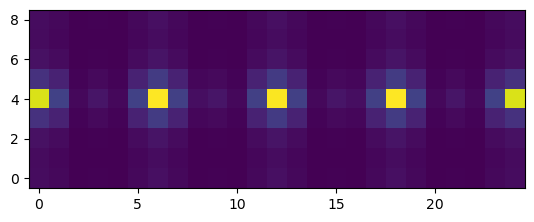

PyObject <matplotlib.image.AxesImage object at 0x292dcf880>

In [14]:
# Af_a[:, i]でi列目を取り出す

size_A = size(Af_a)

#A_aa = fftshift(fft(Af_a, 1)) / Rey

#A_aa = fftshift(fft(Af_a, 1)) / Rey

A_aa = zeros(Complex{Float64}, Rey, nnn)

for i in 1 : nnn

    A_aa[:, i] = (1 / Rey) * fftshift(fft(Af_a[:, i]))
    
end

o_0 = Int((2 + size(A_aa)[1]) / 2)

N = Int(2 * P)

A_aa = A_aa[o_0　 - N  : o_0　 + N , :];

PyPlot.imshow(abs.(A_aa), cmap="viridis", origin="lower")

### 4N + 1 by (2N + 1)^2

A_aa = $\left[
\begin{array}{cc} 
\beta_{1,1}^{-2N} & \beta_{1,2}^{-2N} & ..& \beta_{2,1}^{-2N} & \beta_{2,2}^{-2N} & .. & \beta_{2N+1,2N}^{-2N} & \beta_{2N+1,2N+1}^{-2N}\\
\beta_{1,1}^{-2N+1} & \beta_{1,2}^{-2N+1} & .. & \beta_{2,1}^{-2N+1} & \beta_{2,2}^{-2N+1} & .. & \beta_{2N+1,2N}^{-2N+1} & \beta_{2N+1,2N+1}^{-2N+1} \\ .. & & & .. & & & .. \\ .. & & & .. & & & ..
\\ \beta_{1,1}^{2N} & \beta_{1,2}^{2N} & .. & \beta_{2,1}^{2N} & \beta_{2,2}^{2N} &  .. & \beta_{2N+1,2N}^{2N} & \beta_{2N+1,2N+1}^{2N}
\end{array}
\right]
$

In [116]:
# function beta is nnの要素で列に詰めていく作業を行う

function beta(array, cols)

    output_matrix = reshape(array, cols, :)

    output_matrix = output_matrix'

    return output_matrix
end

beta (generic function with 1 method)

In [117]:
nn_1 = Int(4*P + 1)

for i in 1:nn_1
    
    beta_i = beta(A_aa[i, :], nn)
    
    eval(Meta.parse("beta_$i = $beta_i"))
end

In [118]:
beta_values = zeros(Complex{Float64}, nn_1, nn, nn)

for i in 1:nn_1
    beta_i = beta(A_aa[i, :], nn)
    eval(Meta.parse("beta_$i = $beta_i"))
    beta_values[i, :, :] = beta_i 
end

#beta_matrix = [beta_values[i, :, :] for i in 1:nn_1];

#beta_values[2, :, :] - beta_2

#中心　((4P+1)+1)/2

### Input
### 中心 ((4P + 1) + 1)/2

$\left[\begin{array}{cc}\beta^{-2N} & \beta^{-2N+1} & ..... & \beta^{-1} & \beta^{0} & \beta^{2N} ..... & \beta^{2} & \beta^{1}\end{array}
\right]$

In [139]:
beta_matrix_test = [beta_values[i, :, :] for i in nn_1:-1:1];

beta_matrix_test_2 = Vector{Matrix{ComplexF64}}()

for i in (nn_1 + 1) ÷ 2:-1:1
    push!(beta_matrix_test_2, beta_values[i, :, :])
end

#for i in (nn_1 + 1) ÷ 2 + 1:nn_1

for i in 1:(nn_1 + 1) ÷ 2 - 1
    
    #push!(beta_matrix_test_2, beta_values[i, :, :])
    
    push!(beta_matrix_test_2, beta_values[nn_1 - i + 1, :, :])
end

#size(beta_matrix_test_2)
#beta_matrix_test

beta_matrix_test_2[1] - beta_values[5, :, :]
beta_matrix_test_2[9] - beta_values[6, :, :]

5×5 Matrix{ComplexF64}:
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im

$\beta^{n} = \left[
\begin{array}{cc} 
\beta_{1,1}^{n} & \beta_{1,2}^{n} & ..... & \beta_{1,2N}^{n} & \beta_{1,2N+1}^{n}\\ \beta_{2,1}^{n} & \beta_{2,2}^{n} & ..... & \beta_{2,2N}^{n} & \beta_{2,2N+1}^{n} \\ ...\\ \beta_{2N+1,1}^{n} & \beta_{2N+1,2}^{n} & ..... & \beta_{2N+1,2N}^{n} & \beta_{2N+1,2N+1}^{n}
\end{array}
\right]
$

# Block Matrix (2N +1)^2 by (2N +1)^2
$\left[
\begin{array}{cc} 
\beta^{0} & \beta^{-1} & ..... &  ..... & \beta^{-2N}\\ \beta^{1} & \beta^{0} & ..... & \beta^{-2N+1} & \beta^{-2N} \\ ...\\ \beta^{2N} & \beta^{2N-1} & ..... & ..... & \beta^{0}
\end{array}
\right]
$

In [140]:
function create_block_matrix(matrices::Vararg{AbstractMatrix{T}}) where T
    # Get the dimensions of the first input matrix
    if isempty(matrices)
        throw(ArgumentError("At least one input matrix is required."))
    end
    # input matrix の　大きさ
    matrix_size = size(matrices[1])
    #println(matrix_size)
    
    # input した matrix の個数
    num_matrices = length(matrices)
    #println(num_matrices)

    # Check that all input matrices have the same dimensions
    for matrix in matrices
        if size(matrix) != matrix_size
            throw(ArgumentError("Input matrices must have the same shape."))
        end
    end

    # Calculate the size of the block matrix
    block_matrix = zeros(T, matrix_size[1] * num_matrices, matrix_size[2] * num_matrices)

    # Construct the Toeplitz for block matrix　　　　　　
    for i in 1:num_matrices
        for j in 1:num_matrices
            if i == 1
                # For the first row of blocks, use (i+j-2) % num_matrices to access matrices
                block_matrix[(i-1)*matrix_size[1]+1:i*matrix_size[1], (j-1)*matrix_size[2]+1:j*matrix_size[2]] = matrices[(i+j-2) % num_matrices + 1]
            else
                # For the subsequent rows, the access index should be updated
                block_matrix[(1 + num_matrices - i)*matrix_size[1]+1:(num_matrices - (i - 2))*matrix_size[1], (j-1)*matrix_size[2]+1:j*matrix_size[2]] = matrices[(i+j-2) % num_matrices + 1]
            end
        end
    end

    return block_matrix
end

create_block_matrix (generic function with 2 methods)

### create block matrix

### Input

$\left[\begin{array}{cc}A_1 & A_2 & A_3 & ... & A_{n-1} & A_n\end{array}
\right]$

### output

$\left[
\begin{array}{cc} 
A_1 & A_2 & ..... &  ..... & A_n\\ A_n & A_1 & ..... & A_{n-2} & A_{n-1} \\ ...\\ A_2 & A_3 & ..... & ..... & A_1
\end{array}
\right]
$

### Block Matrix (2N +1)^2 by (2N +1)^2
$\left[
\begin{array}{cc} 
\beta^{0} & \beta^{-1} & ..... &  ..... & \beta^{-2N}\\ \beta^{1} & \beta^{0} & ..... & \beta^{-2N+1} & \beta^{-2N} \\ ...\\ \beta^{2N} & \beta^{2N-1} & ..... & \beta^{1} & \beta^{0}
\end{array}
\right]
$

### つまりInputは

### Input

$\left[\begin{array}{cc}\beta^{0} & \beta^{-1} & ..... & \beta^{-2N+1} & \beta^{-2N} & \beta^{2N} ..... & \beta^{2} & \beta^{1}\end{array}
\right]$

$\left[\begin{array}{cc}\beta_{2P + 1} & \beta_{2P} & ..... & \beta_{2} & \beta_{0} & \beta_{4P+1} ..... & \beta_{2P+3} & \beta_{2P+2}\end{array}
\right]$

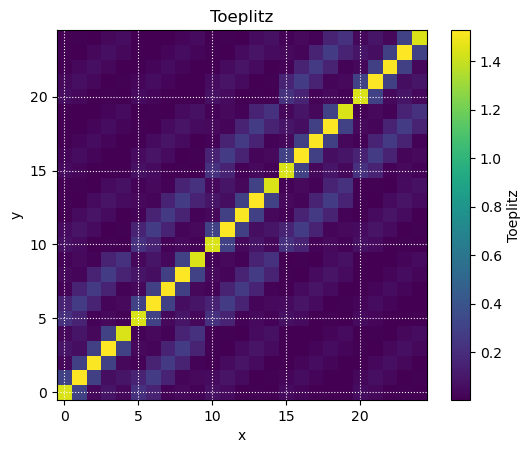

25×25 Matrix{Float64}:
 1.44395     0.299039    0.036091    …  0.00455256  0.0113136   0.00443299
 0.299039    1.52842     0.29172        0.0367979   0.00764009  0.0113136
 0.036091    0.29172     1.52196        0.0658412   0.0367979   0.00455256
 0.08969     0.0605678   0.29172        0.0367979   0.0666558   0.0377211
 0.0351431   0.08969     0.036091       0.00455256  0.0377211   0.0559997
 0.223993    0.150881    0.0182098   …  0.00375147  0.0093228   0.00365294
 0.150881    0.266617    0.147188       0.0303228   0.00629571  0.0093228
 0.0182098   0.147188    0.263358       0.0542555   0.0303228   0.00375147
 0.0452532   0.0305596   0.147188       0.0303228   0.0549267   0.0310836
 0.0177315   0.0452532   0.0182098      0.00375147  0.0310836   0.0461458
 0.0692181   0.046625    0.00562716  …  0.00562716  0.0139841   0.00547936
 0.046625    0.0823894   0.0454838      0.0454838   0.00944349  0.0139841
 0.00562716  0.0454838   0.0813825      0.0813825   0.0454838   0.00562716
 0.013984

In [141]:
@pyimport sys

pushfirst!(PyVector(pyimport("sys")["path"]), "/Users/ikumakiyoshi/Library/Mobile Documents/com~apple~CloudDocs/study_optics/Jupyter/2D_RCWA_julia_debug_2")

using PyCall

@pyimport Block_Toeplitz as bt

#beta_block = bt.create_block_matrix(beta_1, beta_2, beta_3, beta_4, beta_5, beta_6, beta_7, beta_8, beta_9);

#beta_block = bt.create_block_matrix(beta_13, beta_12, beta_11, beta_10, beta_9, beta_8, beta_7, beta_6, beta_5, beta_4, beta_3, beta_2, beta_1);

#beta_block = bt.create_block_matrix(beta_7, beta_8, beta_9, beta_10, beta_11, beta_12, beta_13, beta_1, beta_2, beta_3, beta_4, beta_5, beta_6);

#beta_block_1 = bt.create_block_matrix(beta_7, beta_6, beta_5, beta_4, beta_3, beta_2, beta_1, beta_13, beta_12, beta_11, beta_10, beta_9, beta_8);

#beta_block = bt.create_block_matrix(beta_17, beta_16, beta_15, beta_14, beta_13, beta_12, beta_11, beta_10, beta_9, beta_8, beta_7, beta_6, beta_5, beta_4, beta_3, beta_2, beta_1);

#beta_block = bt.create_block_matrix(beta_9, beta_10, beta_11, beta_12, beta_13, beta_14, beta_15, beta_16, beta_17, beta_1, beta_2, beta_3, beta_4, beta_5, beta_6, beta_7, beta_8);

#beta_block = create_block_matrix(beta_matrix)

#beta_block = create_block_matrix(beta_matrix_test)

#beta_block_1 = create_block_matrix(beta_matrix_test_2)

beta_block = create_block_matrix(beta_matrix_test_2)
beta_block_1 = create_block_matrix(beta_matrix_test_2)

# remove
N_0 = size(beta_1)[1]

N_1 = N_0^2

beta_block = beta_block[1:N_1, 1:N_1]
beta_block_1 = beta_block[1:N_1, 1:N_1]

# diferences 
d_beta = beta_block - beta_block_1;

#PyPlot.imshow(abs.(beta_11), cmap="viridis", origin="lower")
PyPlot.imshow(abs.(beta_block), cmap="viridis", origin="lower")
#PyPlot.imshow(abs.(d_beta), cmap="viridis", origin="lower")
PyPlot.colorbar(label="Toeplitz")
PyPlot.xlabel("x")
PyPlot.ylabel("y")
PyPlot.grid(true, linestyle="dotted", color="white")
PyPlot.title("Toeplitz")
PyPlot.show()

#d_beta
abs.(beta_block)

# Complete function of Toeplitz x to y

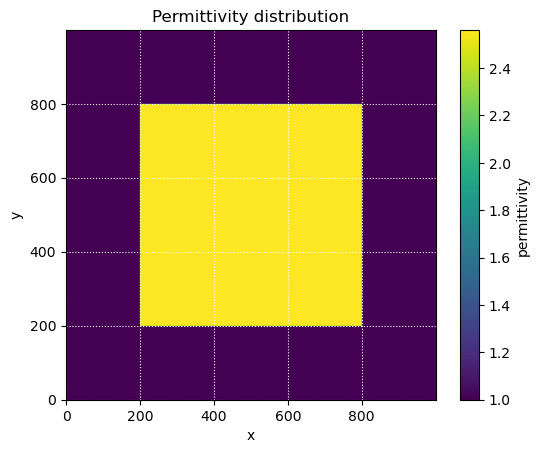

In [142]:
include("Toeplitz_x_to_y.jl")

P = 2

Nx = 1000
Ny = 1000

y_start = 200
x_start = 200
y_end = 800
x_end = 800
n = 1.6^2
angle = 0

nn = Int(P * 2 + 1)

beta_test = beta_n(Nx, Ny, x_start, x_end, y_start, y_end, n, angle, P);

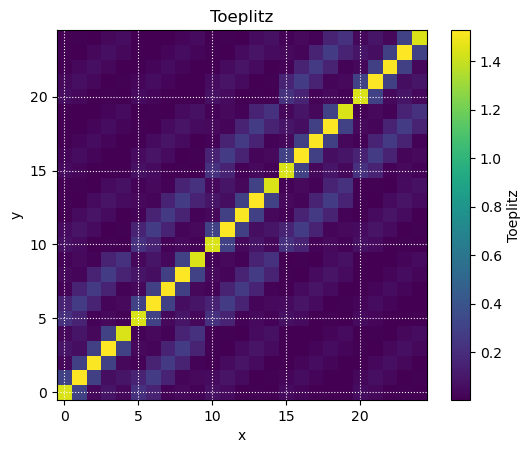

In [143]:
PyPlot.imshow(abs.(beta_test), cmap="viridis", origin="lower")
PyPlot.colorbar(label="Toeplitz")
PyPlot.xlabel("x")
PyPlot.ylabel("y")
PyPlot.grid(true, linestyle="dotted", color="white")
PyPlot.title("Toeplitz")
PyPlot.show()

In [144]:
abs.(beta_test) - abs.(beta_block)

25×25 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

In [44]:
using FFTW


A = [1 2 3; 4 5 6; 7 8 9]
B = [1 21 32 19 11 21]

# y fft
A_fft = fftshift(fft(A, 1))

# even fft
B_fft = fftshift(fft(B))
#print(B_fft)

1×6 Matrix{ComplexF64}:
 -17.0+0.0im  -22.5-18.1865im  …  -18.5-18.1865im  -22.5+18.1865im

In [7]:
reverse([1 2 3 4 5 6])

1×6 Matrix{Int64}:
 6  5  4  3  2  1

In [33]:
#fftshift(fft(A[1,:]))
#fftshift(fft([1 2 3]))

A = [1 2 3 4 5 6]
AA = A[1, :]

#print(A - AA)

Toeplitz(A[1:4], A[1:4]) - Toeplitz(AA[1:4], AA[1:4])

4×4 Toeplitz{Int64, Vector{Int64}, Vector{Int64}}:
 0  0  0  0
 0  0  0  0
 0  0  0  0
 0  0  0  0

In [31]:
fftshift(fft([3 6 9]))

1×3 Matrix{ComplexF64}:
 -4.5-2.59808im  18.0+0.0im  -4.5+2.59808im

In [32]:
input_array = [1 2 3 4 5 6 7 8 9 10 11 12] 

cols = 2

output_matrix = reshape(input_array, cols, :)

output_matrix = output_matrix'

output_matrix

6×2 adjoint(::Matrix{Int64}) with eltype Int64:
  1   2
  3   4
  5   6
  7   8
  9  10
 11  12

In [50]:
test = zeros(Complex{Float64}, 5, 5)

A = [1 2 3 4 5]
B = [1 2 3 4 5]
C = [1 2 3 4 5]
D = [1 2 3 4 5]
E = [1 2 3 4 5]

test[1,:] = A

test

5×5 Matrix{ComplexF64}:
 1.0+0.0im  2.0+0.0im  3.0+0.0im  4.0+0.0im  5.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im

In [34]:
test_2 = [1 2 3; 4 5 6; 7 8 9]

vec(test_2')'
#vec(test_2)'

1×9 adjoint(reshape(adjoint(::Matrix{Int64}), 9)) with eltype Int64:
 1  2  3  4  5  6  7  8  9

In [35]:
import LinearAlgebra

function create_block_matrix(matrices::Vararg{AbstractMatrix{T}}) where T
    # Get the dimensions of the first input matrix
    if isempty(matrices)
        throw(ArgumentError("At least one input matrix is required."))
    end
    matrix_size = size(matrices[1])

    num_matrices = length(matrices)

    # Check that all input matrices have the same dimensions
    for matrix in matrices
        if size(matrix) != matrix_size
            throw(ArgumentError("Input matrices must have the same shape."))
        end
    end

    # Calculate the size of the block matrix
    block_matrix = zeros(T, matrix_size[1] * num_matrices, matrix_size[2] * num_matrices)

    # Construct the block matrix
    for i in 1:num_matrices
        for j in 1:num_matrices
            block_matrix[(i-1)*matrix_size[1]+1:i*matrix_size[1], (j-1)*matrix_size[2]+1:j*matrix_size[2]] = matrices[(i+j-2) % num_matrices + 1]
        end
    end

    return block_matrix
end

create_block_matrix (generic function with 2 methods)

In [36]:
A = [1 2 3; 4 5 6; 7 8 9]
B = [3 4 5; 6 7 8; 9 10 11]

AA = [1 2 3; 4 5 6]
BB = [3 4 5; 6 7 8]

create_block_matrix(AA, BB)

4×6 Matrix{Int64}:
 1  2  3  3  4  5
 4  5  6  6  7  8
 3  4  5  1  2  3
 6  7  8  4  5  6

In [22]:
using LinearAlgebra

A = cat([1 2; 3 4], [5 6; 7 8], [5 6; 7 8], dims=3)

N = 2

AA = [A[:, :, i] for i in 1:N]

print(AA[:, 1])

#create_block_matrix(AA)

[[1 2; 3 4], [5 6; 7 8]]

In [57]:
AA = [1 2 3; 4 5 6]

size(AA)
AA

2×3 Matrix{Int64}:
 1  2  3
 4  5  6

In [134]:
function create_block_matrix(matrices::Vararg{AbstractMatrix{T}}) where T
    # Get the dimensions of the first input matrix
    if isempty(matrices)
        throw(ArgumentError("At least one input matrix is required."))
    end
    # input matrix の　大きさ
    matrix_size = size(matrices[1])
    println(matrix_size)
    
    # input した matrix の個数
    num_matrices = length(matrices)
    println(num_matrices)

    # Check that all input matrices have the same dimensions
    for matrix in matrices
        if size(matrix) != matrix_size
            throw(ArgumentError("Input matrices must have the same shape."))
        end
    end

    # Calculate the size of the block matrix
    block_matrix = zeros(T, matrix_size[1] * num_matrices, matrix_size[2] * num_matrices)

    # Construct the Toeplitz for block matrix　　　　　　
    for i in 1:num_matrices
        for j in 1:num_matrices
            block_matrix[(i-1)*matrix_size[1]+1:i*matrix_size[1], (j-1)*matrix_size[2]+1:j*matrix_size[2]] = matrices[(i+j-2) % num_matrices + 1]
        end
    end

    return block_matrix
end


A = [1 2 3; 4 5 6; 7 8 9]
B = [3 4 5; 6 7 8; 9 10 11]
C = [23 24 25; 26 27 28; 29 210 211]


AA = [1 2 3; 4 5 6]
BB = [3 4 5; 6 7 8]

AAA = [1 2; 4 5; 11 12]
BBB = [3 4; 6 7; 13 14]
CCC = [9 8; 19 31; 15 16]

create_block_matrix(AAA, BBB, CCC)
#bt.create_block_matrix(A, B, C)

(3, 2)
3


9×6 Matrix{Int64}:
  1   2   3   4   9   8
  4   5   6   7  19  31
 11  12  13  14  15  16
  3   4   9   8   1   2
  6   7  19  31   4   5
 13  14  15  16  11  12
  9   8   1   2   3   4
 19  31   4   5   6   7
 15  16  11  12  13  14

In [7]:
#これが正しいやつ

function create_block_matrix(matrices::Vararg{AbstractMatrix{T}}) where T
    # Get the dimensions of the first input matrix
    if isempty(matrices)
        throw(ArgumentError("At least one input matrix is required."))
    end
    # input matrix の　大きさ
    matrix_size = size(matrices[1])
    #println(matrix_size)
    
    # input した matrix の個数
    num_matrices = length(matrices)
    #println(num_matrices)

    # Check that all input matrices have the same dimensions
    for matrix in matrices
        if size(matrix) != matrix_size
            throw(ArgumentError("Input matrices must have the same shape."))
        end
    end

    # Calculate the size of the block matrix
    block_matrix = zeros(T, matrix_size[1] * num_matrices, matrix_size[2] * num_matrices)

    # Construct the Toeplitz for block matrix　　　　　　
    for i in 1:num_matrices
        for j in 1:num_matrices
            if i == 1
                # For the first row of blocks, use (i+j-2) % num_matrices to access matrices
                block_matrix[(i-1)*matrix_size[1]+1:i*matrix_size[1], (j-1)*matrix_size[2]+1:j*matrix_size[2]] = matrices[(i+j-2) % num_matrices + 1]
            else
                # For the subsequent rows, the access index should be updated
                block_matrix[(1 + num_matrices - i)*matrix_size[1]+1:(num_matrices - (i - 2))*matrix_size[1], (j-1)*matrix_size[2]+1:j*matrix_size[2]] = matrices[(i+j-2) % num_matrices + 1]
            end
        end
    end

    return block_matrix
end


A = [1 2 3; 4 5 6; 7 8 9]
B = [3 4 5; 6 7 8; 9 10 11]

AA = [1 2 3; 4 5 6]
BB = [7 8 9; 10 11 12]
CC = [13 14 15; 16 17 18]
DD = [19 20 21; 22 23 24]
EE = [25 26 27; 28 29 30]

AAA = [1 2; 4 5; 11 12]
BBB = [3 4; 6 7; 13 14]
CCC = [9 8; 19 31; 15 16]
DDD = [29 28; 29 21; 25 26]


create_block_matrix(AAA, BBB, CCC, DDD)
FF = create_block_matrix(AA, BB, CC, DD, EE)

10×15 Matrix{Int64}:
  1   2   3   7   8   9  13  14  15  19  20  21  25  26  27
  4   5   6  10  11  12  16  17  18  22  23  24  28  29  30
 25  26  27   1   2   3   7   8   9  13  14  15  19  20  21
 28  29  30   4   5   6  10  11  12  16  17  18  22  23  24
 19  20  21  25  26  27   1   2   3   7   8   9  13  14  15
 22  23  24  28  29  30   4   5   6  10  11  12  16  17  18
 13  14  15  19  20  21  25  26  27   1   2   3   7   8   9
 16  17  18  22  23  24  28  29  30   4   5   6  10  11  12
  7   8   9  13  14  15  19  20  21  25  26  27   1   2   3
 10  11  12  16  17  18  22  23  24  28  29  30   4   5   6

In [9]:
#PyPlot.imshow(abs.(FF), cmap="viridis", origin="lower")

In [361]:
A = [1 2 3; 4 5 6; 7 8 9]

AA = fft(A, 2)

#AAA = fftshift(fft(A, 2))

3×3 Matrix{ComplexF64}:
  6.0+0.0im  -1.5+0.866025im  -1.5-0.866025im
 15.0+0.0im  -1.5+0.866025im  -1.5-0.866025im
 24.0+0.0im  -1.5+0.866025im  -1.5-0.866025im

In [363]:
print(A[:,1])

[1, 4, 7]

In [352]:
fftshift(fft([1 2 3]))

1×3 Matrix{ComplexF64}:
 -1.5-0.866025im  6.0+0.0im  -1.5+0.866025im

In [49]:
function beta(array, cols)

    output_matrix = reshape(array, cols, :)

    output_matrix = output_matrix'

    return output_matrix
end

beta (generic function with 1 method)

In [50]:
beta_values = zeros(Complex{Float64}, nn_1, nn, nn)

for i in 1:nn_1
    beta_i = beta(A_aa[i, :], nn)
    eval(Meta.parse("beta_$i = $beta_i"))
    beta_values[i, :, :] = beta_i 
end

In [60]:
A = [1 2 3 4 5 6 7 8 9 10]

beta(A, 5)


2×5 adjoint(::Matrix{Int64}) with eltype Int64:
 1  2  3  4   5
 6  7  8  9  10

$\left[\begin{array}{cc}\beta_{2P + 1} & \beta_{2P} & ..... & \beta_{2} & \beta_{0} & \beta_{4P+1} ..... & \beta_{2P+3} & \beta_{2P+2}\end{array}
\right]$

$\left[\begin{array}{cc}AAA & BBB & CCC & DDD & GGG & HHH & III\end{array}
\right]$

$\left[\begin{array}{cc}DDD & CCC & BBB & AAA & III & HHH & GGG\end{array}
\right]$

In [107]:
AAA = [1 2; 4 5; 11 12]
BBB = [3 4; 6 7; 13 14]
CCC = [9 8; 19 31; 15 16]
DDD = [29 28; 29 21; 25 26]
GGG = [33 38; 39 31; 35 36]
HHH = [49 48; 49 41; 45 46]
III = [59 58; 59 51; 55 56]

#EEE = [AAA, BBB, CCC, DDD]

EEE = [AAA, BBB, CCC, DDD, GGG, HHH, III]

a = length(EEE)

JJJ = Vector{Matrix{Int64}}()

for i in (a + 1) ÷ 2:-1:1
    push!(JJJ, EEE[i])
end

#for i in (a + 1) ÷ 2 + 1:a
for i in 1:(a + 1) ÷ 2 - 1
    push!(JJJ, EEE[a - i + 1])
end

JJJ

7-element Vector{Matrix{Int64}}:
 [29 28; 29 21; 25 26]
 [9 8; 19 31; 15 16]
 [3 4; 6 7; 13 14]
 [1 2; 4 5; 11 12]
 [59 58; 59 51; 55 56]
 [49 48; 49 41; 45 46]
 [33 38; 39 31; 35 36]

In [76]:
AAA = [1 2; 4 5; 11 12]
BBB = [3 4; 6 7; 13 14]
CCC = [9 8; 19 31; 15 16]
DDD = [29 28; 29 21; 25 26]
GGG = [33 38; 39 31; 35 36]
HHH = [49 48; 49 41; 45 46]
III = [59 58; 59 51; 55 56]

EEE = [AAA, BBB, CCC, DDD]

EEE[1]

3×2 Matrix{Int64}:
  1   2
  4   5
 11  12